# First pass analysis of line/loop data

<ul>
    <li> Analyse correct sequence lengths. </li>
    <li> Do reaction times </li>
    <li> Analyse as a function of distance from reward </li>
    <li> Try to fit RL model to these data </li> 
    
</ul>

<b> WHY IS THERE A DIFFERENCE BETWEEN REW_LIST AND DAT_DICT['STATE'] </b>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import scipy.stats as stt
seaborn.set(font_scale=1.5,style='ticks')
import os
import re
import sys
import itertools
import networkx as nx
clrs = seaborn.color_palette()

sys.path.append("/Users/Yves/Documents/Code/structural_knowledge/packages/")


sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")


In [2]:
import mouse_poker as mpk

# Defined functions 

In [3]:
poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]

In [4]:
def get_poke_to_state_map(lines):
    """ """
    tmp = []
    for i,j in zip([int(re.findall('POKEDPORT_([0-9])',i)[0]) for i in lines if '_POKEDPORT' in i],
                         [int(re.findall('POKEDSTATE_([0-9])',i)[0]) for i in lines if '_POKEDSTATE' in i]):

        if [i,j] not in tmp:
            tmp.append([i,j])
    poke_to_state_map = [i[1] for i in sorted(tmp)]
    return poke_to_state_map,tmp

In [240]:
def get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=5,maxNrew=100,verbose=False):
    
    """ Checked the reward locations """
    #aa = [int(re.findall('POKEDSTATE_([0-9])',lines[ijk-1])[0]) for ijk,i in enumerate(lines) if 'REW_True' in i]
    perf = np.zeros([9,4])
    perf_ctr = np.zeros([9,4])
    rew_hist = []
    for i,j in enumerate([poke_to_state_map[i] for i in rew_indices]):
        perf[j,i] = np.nan
    for rew_ctr,(st,nd) in enumerate(zip(np.where(dat_dict['rew_list'])[0][:-1]+1,np.where(dat_dict['rew_list'])[0][1:])):
        #print(st,nd)
        #rew_loc = poke_to_state_map[dat_dict['rews'][rew_ctr][0]]
        #c_rew_index = rew_indices.index(dat_dict['rews'][rew_ctr][0])
        rew_loc = dat_dict['state'][nd][0]
        #print(dat_dict['port'][nd][0])
        rew_loc = dat_dict['state'][nd][0]

        c_rew_index = rew_indices.index(dat_dict['port'][nd][0])
        
        if not rew_hist:
            rew_hist.append(rew_loc)
        elif rew_loc==rew_hist[-1]:
            rew_hist.append(rew_loc)
        else:
            rew_hist = []
        

        if np.logical_and(len(rew_hist)>=minNrew,len(rew_hist)<=maxNrew): 
            #print(seq_rews)
            has_visited = []
            #print(st,nd)
            #print('NEXTREW!!!!!!!!!')
            for pk_ctr in range(st,nd):
                if (len(dat_dict['state'][pk_ctr][1])>1) or (dat_dict['state'][pk_ctr][0]==0 or dat_dict['state'][pk_ctr][0]==8):
                    d0 = np.abs(dat_dict['state'][pk_ctr][0]-rew_loc)
                    d1 = np.abs(dat_dict['state'][pk_ctr+1][0]-rew_loc)
                    st_dist = dat_dict['state'][pk_ctr][0]-dat_dict['state'][pk_ctr+1][0]
                    if dat_dict['rew_list'][pk_ctr]:
                        st_dist = 99
                    
                    state = dat_dict['state'][pk_ctr][0]
                    print(state,dat_dict['state'][pk_ctr+1][0],rew_loc)
                    if state not in has_visited:
                        rewarded = dat_dict['rew_list'][pk_ctr]
                        if rewarded:
                            perf[state,c_rew_index] += 1
                            perf_ctr[state,c_rew_index] += 1

                        elif d1<d0:
                            perf[state,c_rew_index] += 1
                            perf_ctr[state,c_rew_index] += 1
                        else:
                            perf[state,c_rew_index] += 0
                            perf_ctr[state,c_rew_index] += 1
                else:
                    print("GUIDED")
                        
    return perf,perf_ctr

In [241]:
poke_to_state_map

[5, 2, 8, 3, 6, 7, 4, 0, 1]

In [242]:
#aa = [int(re.findall('POKEDSTATE_([0-9])',lines[ijk-1])[0]) for ijk,i in enumerate(lines) if 'REW_True' in i]

In [243]:
#poke_to_state_map

# Actual code to run stuff 

In [244]:
#print(day_df['filepath'].values[ix])
f = open("/Users/yweissenberger/Documents/Pycontrol/data/line_loop_batch_4_RUNNAVI/'456675_3'-2021-03-05-120244.txt",'r')
#f = open("/Users/yweissenberger/Documents/Pycontrol/data/line_loop_batch_4_RUNNAVI/'456675_3'-2021-03-03-105842.txt",'r')
#f = open("/Users/yweissenberger/Documents/Pycontrol/data/line_loop_batch_4_RUNNAVI/'456675_3'-2021-03-05-142010.txt",'r')  #test session

#f = open("/Volumes/hpc_dat/pycontrol/data/line_loop_batch_4_RUNNAVI/'456675_3'-2021-02-12-121633.txt",'r')
#f = open("/Users/yves/Documents/beh_dat_new_room/'456675_10'-2021-02-17-110616.txt",'r')

lines =f.readlines()
experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)
print(nRews)

143


In [245]:

poke_to_state_map,_ = get_poke_to_state_map(lines)
rew_indices = [0,3,5,8]
rew_indices = [eval(re.findall('REWARD LOCATIONS(\[.*\])',l)[0]) for l in lines if re.findall('REWARD LOCATIONS(\[.*\])',l)][0]


In [246]:
poke_to_state_map

[5, 2, 8, 3, 6, 7, 4, 0, 1]

In [247]:
[lines[ix-1] for ix,i in enumerate(lines) if 'REW_True' in i][:10]

['P 3752 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[6, 8]_NOWSTATE_7\n',
 'P 10925 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[4, 6]_NOWSTATE_5\n',
 'P 16045 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[1]_NOWSTATE_0\n',
 'P 23537 _POKEDSTATE_3_PREVSTATE_2_AVAILSTATES_[4, 6]_NOWSTATE_5\n',
 'P 29723 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[5, 7]_NOWSTATE_6\n',
 'P 41745 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[5, 7]_NOWSTATE_6\n',
 'P 49967 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[0, 2]_NOWSTATE_1\n',
 'P 56551 _POKEDSTATE_3_PREVSTATE_2_AVAILSTATES_[6, 8]_NOWSTATE_7\n',
 'P 63997 _POKEDSTATE_3_PREVSTATE_4_AVAILSTATES_[0, 2]_NOWSTATE_1\n',
 'P 70702 _POKEDSTATE_3_PREVSTATE_2_AVAILSTATES_[5, 7]_NOWSTATE_6\n']

In [248]:
poke_to_state_map

[5, 2, 8, 3, 6, 7, 4, 0, 1]

In [249]:
nR = 0
perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=nR)


6 5 3
5 6 3
6 5 3
5 4 3
4 3 3
4 3 3
1 2 3
2 3 3
6 5 3
5 4 3
4 3 3
5 6 3
6 5 3
5 4 3
4 3 3
5 4 3
4 3 3
2 3 3
6 5 3
5 6 3
6 5 3
5 4 3
4 3 3
2 3 3
5 4 3
4 3 3
1 2 3
2 3 3
2 3 3
7 8 3
8 7 3
7 8 3
8 7 3
7 6 3
6 5 3
5 4 3
4 3 3
8 7 3
7 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 4 3
4 3 3
1 0 3
0 1 3
1 0 3
0 1 3
1 2 3
2 3 3
4 3 3
6 5 3
5 4 3
4 3 3
4 3 3
7 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
GUIDED
GUIDED
GUIDED
1 2 3
2 3 3
1 2 3
2 3 3
6 5 3
5 6 3
6 5 3
5 4 3
4 3 3
3 2 7
2 3 7
3 2 7
2 3 7
3 2 7
2 3 7
3 4 7
4 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
GUIDED
GUIDED
GUIDED
GUIDED
6 5 7
5 6 7
6 5 7
5 6 7
6 5 7
5 4 7
4 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 2 7
2 1 7
1 2 7
GUIDED
GUIDED
GUIDED
GUIDED
GUIDED
2 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 2 7
2 3 7
3 2 7
2 3 7
3 4 7
4 3 7
3 2 7
2 3 7
GUIDED
GUIDED
GUIDED
GUIDED
2 3 7
3 4 7
4 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 4 7
4 3 7
GUIDED
GUIDED
GUIDED
GUIDED
3 2 7
2 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 

In [250]:
np.nansum(perf)/np.nansum(perf_ctr)

0.5811232449297972

In [251]:
np.nanmean(perf/perf_ctr)

<ipython-input-251-b1b594a67bfa>:1: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean(perf/perf_ctr)


0.6869867757011544

In [232]:
perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=nR,maxNrew=nR)
fc = perf/perf_ctr


3 2 7
2 3 7
3 2 7
2 3 7
3 2 7
2 3 7
3 4 7
4 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
4 5 1
5 6 1
6 7 1
7 8 1
8 7 1
7 6 1
6 5 1
5 6 1
6 5 1
5 6 1
6 7 1
7 8 1
8 7 1
7 8 1
8 7 1
1 2 5
2 1 5
1 2 5
2 3 5
3 2 5
2 1 5
1 2 5
2 3 5
3 2 5
2 1 5
1 0 5
0 1 5
1 2 5
2 3 5
3 2 5
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 4 7
4 5 7
5 6 7
6 5 7
5 6 7
6 5 7
5 6 7
6 5 7
5 6 7
6 5 7
7 8 3
8 7 3
7 6 3
6 7 3
7 6 3
6 5 3
5 4 3
4 5 3
5 6 3
6 7 3
7 8 3
8 7 3
7 6 3
6 5 3
5 6 3
3 2 7
2 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 2 7


<ipython-input-232-683cdbc5c269>:2: RuntimeWarning: invalid value encountered in true_divide
  fc = perf/perf_ctr


In [233]:
allres = []
for nR in range(0,20):
    print(nR)
    perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=nR,maxNrew=nR)
    fc = perf/perf_ctr
    allres.append(np.nansum(perf/np.nansum(perf_ctr)))
#fc[np.isnan(fc)] = 1
print(np.nanmean(fc))

0
3 2 7
2 3 7
3 2 7
2 3 7
3 2 7
2 3 7
3 4 7
4 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
4 5 1
5 6 1
6 7 1
7 8 1
8 7 1
7 6 1
6 5 1
5 6 1
6 5 1
5 6 1
6 7 1
7 8 1
8 7 1
7 8 1
8 7 1
1 2 5
2 1 5
1 2 5
2 3 5
3 2 5
2 1 5
1 2 5
2 3 5
3 2 5
2 1 5
1 0 5
0 1 5
1 2 5
2 3 5
3 2 5
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 4 7
4 5 7
5 6 7
6 5 7
5 6 7
6 5 7
5 6 7
6 5 7
5 6 7
6 5 7
7 8 3
8 7 3
7 6 3
6 7 3
7 6 3
6 5 3
5 4 3
4 5 3
5 6 3
6 7 3
7 8 3
8 7 3
7 6 3
6 5 3
5 6 3
3 2 7
2 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 2 7
1
6 5 3
5 6 3
6 5 3
5 4 3
4 3 3
6 5 7
5 6 7
6 5 7
5 6 7
6 5 7
5 4 7
4 3 7
3 2 7
2 1 7
1 2 7
2 3 7
3 2 7
2 1 7
1 2 7
2 3 1
3 4 1
4 3 1
3 2 1
2 3 1
3 4 1
4 5 1
5 6 1
6 5 1
5 4 1
4 3 1
3 2 1
2 1 1
7 8 5
8 7 5
7 6 5
6 5 5
0 1 7
1 2 7
2 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 4 7
4 5 7
5 6 7
6 5 7
5 6 7
6 5 7
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
3 2 7
2 1 7
1 2 7
2 3 7
3 4 7
4 5 7
5 4 7
4 3 7
3 4 7
4 5 7
5 4 7


<ipython-input-233-782ed6cfdf64>:5: RuntimeWarning: invalid value encountered in true_divide
  fc = perf/perf_ctr


 3 7
3 2 7
2 3 7
3 4 7
4 5 7
5 4 7
4 5 7
5 6 7
6 5 7
5 4 7
4 3 7
3 2 7
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 7 3
7 6 3
6 5 3
5 6 3
6 5 3
5 6 3
14
8 7 3
7 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 4 3
4 3 3
5 4 7
4 5 7
5 6 7
6 7 7
3 2 1
2 1 1
2 3 5
3 2 5
2 3 5
3 4 5
4 5 5
1 0 7
0 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 0 7
0 1 7
1 2 7
2 1 7
1 0 7
0 1 7
2 3 3
15
1 0 3
0 1 3
1 0 3
0 1 3
1 2 3
2 3 3
4 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 0 7
0 1 7
1 0 7
0 1 7
1 0 7
0 1 7
1 0 7
0 1 7
1 2 7
2 3 7
5 6 1
6 5 1
5 6 1
6 5 1
5 6 1
6 5 1
5 6 1
6 5 1
5 6 1
6 5 1
5 4 1
4 3 1
3 2 1
2 1 1
2 3 5
3 2 5
2 3 5
3 2 5
2 3 5
3 2 5
2 1 5
1 0 5
0 1 5
1 2 5
2 3 5
3 4 5
4 5 5
4 5 7
5 6 7
6 7 7
4 3 3
16
4 3 3
4 3 7
3 2 7
2 3 7
3 4 7
4 5 7
5 4 7
4 5 7
5 4 7
4 3 7
3 4 7
4 3 7
3 2 7
2 1 7
1 0 7
0 1 7
5 6 1
6 5 1
5 6 1
6 5 1
5 4 1
4 3 1
3 2 1
2 1 1
6 5 5
1 2 7
2 3 7
3 4 7
4 5 7
5 6 7
6 5 7
5 4 7
4 3 7
3 2 7
2 1 7
1 0 7
0 1 7
1 2 7
2 3 7
3 4 7
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 6 3
6 5 3
5 4 3
4 

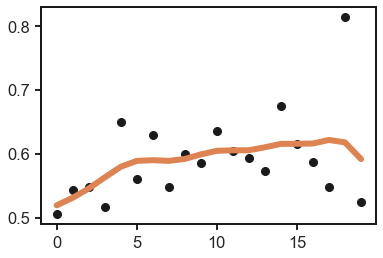

In [252]:
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(allres,1.5,mode='nearest'),color=clrs[1],linewidth=6)
plt.scatter(range(len(allres)),allres,s=64,color='k')

In [253]:
#perf[np.where(perf_ctr==0)[0],np.where(perf_ctr==0)[1],np.where(perf_ctr==0)[2]] = np.nan

In [254]:
#plt.plot(gaussian_filter1d(np.nanmean(perf/perf_ctr,axis=(0,1)),2,mode='nearest'))

In [255]:
edges_state = [[i,i+1] for i in range(8)]
edges_state.extend([i+1,i] for i in range(8))    
edges = []
for e1,e2 in edges_state:
    edges.append([poke_to_state_map.index(e1),poke_to_state_map.index(e2)])

In [256]:
ix = 1
c_rew_index = poke_to_state_map[rew_indices[ix]]

good_edges = [[poke_to_state_map.index(0),poke_to_state_map.index(1)],
              [poke_to_state_map.index(8),poke_to_state_map.index(7)]]
bad_edges = []
for s in range(1,8):
    if s!=c_rew_index:
        d1 = np.abs(c_rew_index-(s+1))
        d2 = np.abs(c_rew_index-(s-1))
        min_ = np.argmin([d1,d2])
        max_ = np.argmax([d1,d2])

        good_edges.append([poke_to_state_map.index(s),poke_to_state_map.index([s+1,s-1][min_])])
        bad_edges.append([poke_to_state_map.index(s),poke_to_state_map.index([s+1,s-1][max_])])

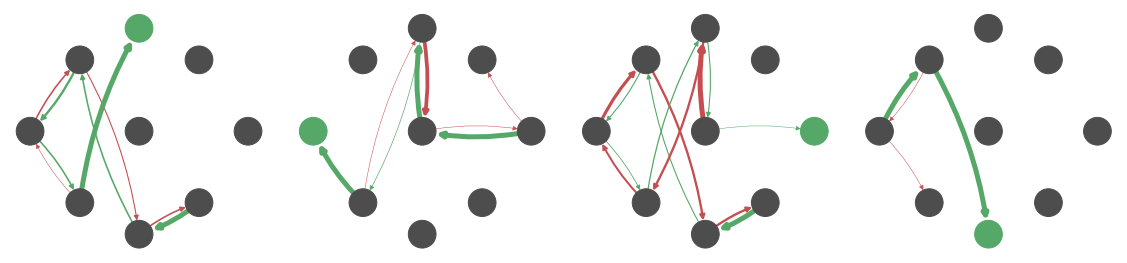

In [257]:
plt.figure(figsize=(16,4))
for ix in range(4):
    plt.subplot(1,4,ix+1)
    #ix = 1
    c_rew_index = poke_to_state_map[rew_indices[ix]]

    good_edges = [[poke_to_state_map.index(0),poke_to_state_map.index(1)],
                  [poke_to_state_map.index(8),poke_to_state_map.index(7)]]
    bad_edges = []
    for s in range(1,8):
        if s!=c_rew_index:
            d1 = np.abs(c_rew_index-(s+1))
            d2 = np.abs(c_rew_index-(s-1))
            min_ = np.argmin([d1,d2])
            max_ = np.argmax([d1,d2])

            good_edges.append([poke_to_state_map.index(s),poke_to_state_map.index([s+1,s-1][min_])])
            bad_edges.append([poke_to_state_map.index(s),poke_to_state_map.index([s+1,s-1][max_])])




    pos = np.array([1,-1])*poke_pos
    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos)
    nx.draw(G0,pos=pos,alpha=.2)
    G = nx.DiGraph()
    weights = []

    for e in good_edges:
        G.add_edge(e[0],e[1],weight=fc[poke_to_state_map[e[0]],ix],color='g')
        #weights.append(3*fc[poke_to_state_map[e[0]],ix])

    for e in bad_edges:
        G.add_edge(e[0],e[1],weight=1-fc[poke_to_state_map[e[0]],ix],color='r')
        #weights.append(3*fc[poke_to_state_map[e[0]],ix])

    #G.add_edges_from([i for i in good_edges if None not in i])
    weights = nx.get_edge_attributes(G,'weight')
    colors = nx.get_edge_attributes(G,'color')
    node_colors = ['.3' for _ in range(9)]
    node_colors[[7,5,3,1][ix]] = 'g'
    nx.draw(G,
        pos=pos,
            width=(10**(np.array(list(weights.values()))))/2,
            edge_color=np.array(list(colors.values())),
            connectionstyle="arc3,rad=-0.1",
            node_color=node_colors,
            node_size=768)
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/tpf/navi_decisions.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_decisions.png",dpi=300)


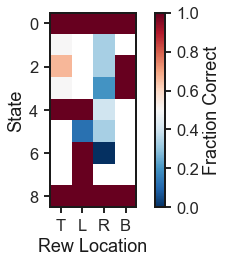

In [258]:
sqr = fc
sqr[0] = 1
sqr[-1] = 1
plt.imshow(sqr,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlabel("Rew Location")
plt.xticks([0,1,2,3],['T','L','R','B'])
plt.ylabel("State")
cbar = plt.colorbar()
cbar.set_label("Fraction Correct")
plt.tight_layout()

In [79]:
fc = perf/perf_ctr
fc[np.isnan(fc)] = 1

<ipython-input-79-52fb409a140d>:1: RuntimeWarning: invalid value encountered in true_divide
  fc = perf/perf_ctr


In [80]:
fc

array([[1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 0.75],
       [1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , 1.  ]])

# Performance history

In [81]:
ROOT = "/Users/yweissenberger/Documents/Pycontrol/data/line_loop_batch_4_RUNNAVI/"#/Users/yves/Documents/behavior_data/line_loop_cohort_1/line_loop_batch_4_RUNNAVI/'
fs = sorted([os.path.join(ROOT,i) for i in os.listdir(ROOT) if '.txt' in i])
perf_hist = []
all_fc  = []
all_perf = np.zeros([9,4])
all_ctr = np.zeros([9,4])
for f_ in fs[:-1]:
    try:
        f = open(f_,'r')
        lines =f.readlines()
        experiment_name, task_name, subject_id, task_nr, graph,lineloop,date,test,_ = mpk.load.get_metadata(lines)
        dat_dict,events,event_times,nRews,_ = mpk.load.parse_data(lines,experiment_name)

        #poke_to_state_map = get_poke_to_state_map(lines)
        rew_indices = [0,3,5,8]
        perf,perf_ctr = get_performance(dat_dict,poke_to_state_map,rew_indices,lines,minNrew=20)

        fc = perf/perf_ctr
        all_perf += perf
        all_ctr += perf_ctr
        all_fc.append(fc)
        perf_hist.append(np.nanmean(fc))
    except:
        pass

NEXTREW!!!!!!!!!
7 6 3 1
6 5 3 1
5 4 3 1
4 5 3 1
5 4 3 1
4 5 3 1
5 4 3 1
4 5 3 1
5 4 3 1
4 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
6 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
5 4 3 1
4 5 3 1
5 6 3 1
6 5 3 1
5 6 3 1
6 7 3 1
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
6 5 3 1
5 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
7 8 3 1
8 7 3 1
7 8 3 1
8 7 3 1
7 8 3 1
8 7 3 1
7 8 3 1
8 7 3 1
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
4 5 3 1
5 6 3 1
6 7 3 1
7 6 3 1
6 5 3 1
5 6 3 1
6 7 3 1
7 8 3 1
8 7 3 1
7 8 3 1
8 7 3 1
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
6 5 3 1
5 6 3 1
6 5 3 1
5 4 3

<ipython-input-81-7fd4eac7e435>:18: RuntimeWarning: invalid value encountered in true_divide
  fc = perf/perf_ctr


NEXTREW!!!!!!!!!
8 7 3 1
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 4 3 1
4 5 3 1
5 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
7 8 3 1
8 7 3 1
7 8 3 1
8 7 3 1
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 4 3 1
4 5 3 1
5 4 3 1
4 5 3 1
5 6 3 1
6 7 3 1
7 6 3 1
6 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
4 5 3 1
5 6 3 1
6 5 3 1
5 4 3 1
4 5 3 1
5 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
1 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 4 2 7
4 3 2 7
3 2 2 7
2 1 2 7
1 2 2 7
2 1 2 7
1 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
0 1 2 7
1 0 2 7
0 1 2 7
1 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 4 2 7
4 3 2 7
3 4 2 7
4 5 2 7
5 4 2 7
4 5 2 7
5 4 2 7
4 5 2 7
5 6 2 7
6 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
1 2 2 7
2 3 2 7
3 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
2 3 2 7
3 4 2 7
4 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
4 3 2 7
3 4 2 7

NEXTREW!!!!!!!!!
6 5 3 1
5 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
3 4 2 7
4 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
6 7 2 7
NEXTREW!!!!!!!!!
1 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 4 2 7
4 3 2 7
3 2 2 7
2 1 2 7
1 2 2 7
2 3 2 7
3 4 2 7
4 3 2 7
3 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
4 3 1 3
NEXTREW!!!!!!!!!
4 3 1 3
NEXTREW!!!!!!!!!
4 3 1 3
NEXTREW!!!!!!!!!
2 3 1 3
NEXTREW!!!!!!!!!
6 7 0 5
7 6 0 5
6 5 0 5
NEXTREW!!!!!!!!!
4 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
7 6 1 3
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
7 6 1 3
6 5 1 3
5 4 1 3
4 5 1 3
5 6 1 3
6 7 1 3
7 6 1 3
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
7 6 1 3
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
6 7 1 3
7 6 1 3
6 7 1 3
7 6 1 3
6 5 1 3
5 6 1 3
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
2 3 1 3
NEXTREW!!!!!!!!!
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
6 5 1 3
5 6 1 3
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
5 4 1 3
4 3 1 3
NEXTREW!!!!!

<ipython-input-81-7fd4eac7e435>:22: RuntimeWarning: Mean of empty slice
  perf_hist.append(np.nanmean(fc))


NEXTREW!!!!!!!!!
1 2 1 3
2 3 1 3
NEXTREW!!!!!!!!!
1 2 1 3
2 3 1 3
NEXTREW!!!!!!!!!
6 5 1 3
5 6 1 3
6 5 1 3
5 4 1 3
4 3 1 3
NEXTREW!!!!!!!!!
6 5 2 7
5 4 2 7
4 3 2 7
3 2 2 7
2 3 2 7
3 4 2 7
4 5 2 7
5 4 2 7
4 5 2 7
5 6 2 7
6 7 2 7
NEXTREW!!!!!!!!!
4 3 3 1
3 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
4 3 3 1
3 4 3 1
4 3 3 1
3 4 3 1
4 3 3 1
3 2 3 1
2 1 3 1
NEXTREW!!!!!!!!!
7 8 0 5
8 7 0 5
7 8 0 5
8 7 0 5
7 8 0 5
8 7 0 5
7 6 0 5
6 5 0 5
NEXTREW!!!!!!!!!
6 5 0 5
NEXTREW!!!!!!!!!
4 3 0 5
3 2 0 5
2 1 0 5
1 2 0 5
2 3 0 5
3 2 0 5
2 1 0 5
1 0 0 5
0 1 0 5
1 2 0 5
2 3 0 5
3 4 0 5
4 5 0 5
NEXTREW!!!!!!!!!
7 6 0 5
6 5 0 5
NEXTREW!!!!!!!!!
2 3 0 5
3 2 0 5
2 1 0 5
1 2 0 5
2 3 0 5
3 2 0 5
2 3 0 5
3 2 0 5
2 3 0 5
3 2 0 5
2 1 0 5
1 0 0 5
0 1 0 5
1 2 0 5
2 3 0 5
3 4 0 5
4 5 0 5
NEXTREW!!!!!!!!!
2 3 0 5
3 2 0 5
2 3 0 5
3 2 0 5
2 1 0 5
1 0 0 5
0 1 0 5
1 2 0 5
2 1 0 5
1 2 0 5
2 3 0 5
3 4 0 5
4 5 0 5
NEXTREW!!!!!!!!!
2 3 2 7
3 2 2 7
2 1 2 7
1 0 2 7
0 1 2 7
1 2 2 7
2 3 2 7
3 2 2 7
2 1 2 7
1 0 2 7
0 1 2 7
1 2

In [82]:
all_perf/all_ctr

<ipython-input-82-b6312f3beb51>:1: RuntimeWarning: invalid value encountered in true_divide
  all_perf/all_ctr


array([[1.        , 1.        , 1.        ,        nan],
       [0.85714286, 0.95833333, 0.51612903,        nan],
       [0.87735849, 0.95      , 0.7260274 , 0.93203883],
       [0.49541284,        nan, 0.5625    , 0.7398374 ],
       [0.96610169, 0.87628866, 0.73076923, 0.78625954],
       [       nan, 0.75728155, 0.71794872, 0.86813187],
       [0.91304348, 0.85057471, 0.78125   , 0.83050847],
       [0.78947368, 0.92857143,        nan, 0.74358974],
       [1.        , 1.        ,        nan, 1.        ]])

In [83]:
stt.binom_test(0.57*400,n=400)

0.00796983057579857

In [84]:
fc

array([[1.        ,        nan, 1.        ,        nan],
       [0.66666667, 1.        , 0.35294118,        nan],
       [0.625     , 1.        , 0.75      , 1.        ],
       [0.27272727,        nan, 0.42857143, 0.4       ],
       [0.75      , 1.        , 0.83333333, 1.        ],
       [       nan, 0.4       , 0.6875    ,        nan],
       [1.        , 1.        , 0.5       ,        nan],
       [0.4       , 0.5       ,        nan,        nan],
       [1.        , 1.        ,        nan,        nan]])

In [85]:
#np.nanmean(all_fc[-5:],axis=0)

[[1.         1.         1.         1.        ]
 [0.88888889 1.         0.67647059        nan]
 [0.87847222 1.         0.75       0.95588235]
 [0.59454545        nan 0.54761905 0.79786096]
 [0.91964286 0.94490132 0.81111111 0.89951923]
 [       nan 0.6971867  0.78472222 0.90277778]
 [0.875      0.90192308 0.83333333 0.93333333]
 [0.85       0.85227273        nan 1.        ]
 [1.         1.         1.         1.        ]]


<ipython-input-86-81c2fe02d6ba>:2: RuntimeWarning: Mean of empty slice
  sqr = np.nanmean(all_fc[-10:],axis=0)


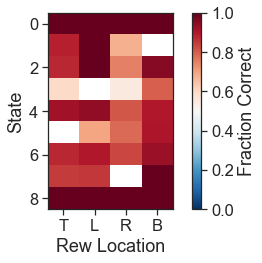

In [86]:
#sqr = all_perf/all_ctr
sqr = np.nanmean(all_fc[-10:],axis=0)
fc = sqr
sqr[0] = 1
sqr[-1] = 1
plt.imshow(sqr,vmin=0,vmax=1,cmap='RdBu_r',aspect=.7)
plt.xlabel("Rew Location")
plt.xticks([0,1,2,3],['T','L','R','B'])
plt.ylabel("State")
cbar = plt.colorbar()
cbar.set_label("Fraction Correct")
#cbar.ax.
plt.tight_layout()
#plt.tight_layout*
#plt.savefig("/Users/yves/Desktop/tpf/navi_frac_corr_by_state.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_frac_corr_by_state.png",dpi=300)
print(sqr)

In [87]:
seaborn.set(font_scale=1.5,style='ticks',rc={'axes.edgecolor': 'k',
                                             'axes.linewidth': 2,
                                             #'xtick.major.size': 6,
                                             'axes.labelcolor':'k',
                                             'xtick.major.width': 2,
                                             'ytick.major.width': 2,
                                             'xtick.major.pad': 5.5,
                                             'ytick.major.pad': 5.5,
                                             'axes.labelsize': 18
                                            })


In [73]:
from scipy.ndimage import gaussian_filter1d

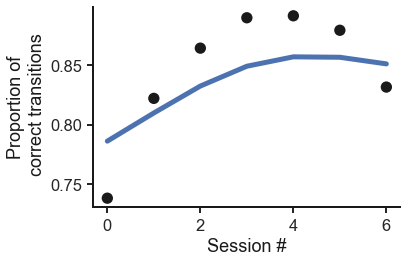

In [74]:
sess_perf = [np.nanmean(i) for i in perf_hist if not np.isnan(np.nanmean(i))][1:]
plt.plot(gaussian_filter1d(sess_perf,2.25,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.xlabel("Session #")
plt.ylabel("Proportion of\n correct transitions")
#plt.xlim(-.5)
seaborn.despine()
plt.tight_layout()
#plt.savefig("/Users/yves/Desktop/tpf/navi_learning.svg")
#plt.savefig("/Users/yves/Desktop/tpf/navi_learning.png",dpi=300)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


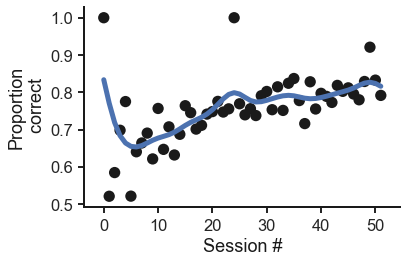

In [73]:
sess_perf = [np.nanmean(i) for i in perf_hist if not np.isnan(np.nanmean(i))][1:]
plt.plot(gaussian_filter1d(sess_perf,2.25,mode='nearest'),linewidth=5)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=128,edgecolors='none')
plt.xlabel("Session #")
plt.ylabel("Proportion\n correct")
#plt.xlim(-.5)
seaborn.despine()
plt.tight_layout()

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


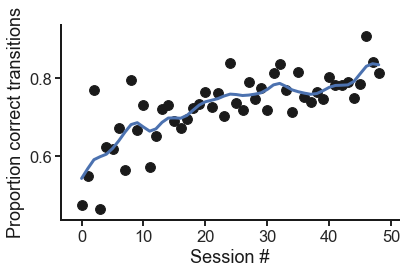

In [157]:
sess_perf = [np.nanmean(i) for i in perf_hist if not np.isnan(np.nanmean(i))][2:]
plt.plot(gaussian_filter1d(sess_perf,1.5),linewidth=3)
plt.scatter(range(len(sess_perf)),sess_perf,color='k',s=96)
plt.xlabel("Session #")
plt.ylabel("Proportion correct transitions")
seaborn.despine()
plt.tight_layout()

In [352]:
sess_perf

[0.49722222222222223,
 0.4375,
 0.575,
 0.7785714285714285,
 0.533253751851708,
 0.6662414947395835,
 0.6223282951941488,
 0.6737401169376257,
 0.5623015873015873,
 0.7999957558781088,
 0.6801653630532941,
 0.7255549534816176,
 0.6285714285714286,
 0.6530097125413526,
 0.7148889066754313,
 0.7511047675485337,
 0.6965651402837558,
 0.6748187242519604,
 0.7148784777376731,
 0.7550147542587059,
 0.737619565377113,
 0.7809430094711312,
 0.7239262720576801,
 0.7749516267766803,
 0.812864219114219,
 0.8291787702735416,
 0.7415101007090994,
 0.8239091239707511,
 0.8041840068465725,
 0.7300002479969016,
 0.8666666666666666,
 0.7148947762687461,
 0.8286583091222216,
 0.843745340022627,
 0.8108984078641084,
 0.7186338736621062,
 0.8182802374871762,
 0.768012650998762,
 0.8241828432867361,
 0.7641757529894638,
 0.7426986029797972,
 0.792046279791378,
 0.7794624634760058,
 0.7853650581919769,
 0.7923093533308587,
 0.8192483509256663,
 0.7656474722385459,
 0.9027777777777777,
 0.8608389450056116,
 